# Øving 4, TMA4320

* **Veiledning:** Torsdag 10.15-12.00 og fredag 08.15-10.00 i R73 og på Zoom. 
* **Innleveringsfrist:** Mandag 28.02, kl. 23.59.
* **Innleveringsmetode** Følgende to krav er nødvendig for godkjenning
    1. Opplasting av Jupyter Notebook (individuelt) i Blackboard
    2. Svare på skjema med kontrollspørsmål i Blackboard (alle spørsmålene må være riktig besvart for godkjenning)
    
Før du starter, gå gjennom notatet: 

* [Numerical solution of ordinary differential equations](http://www.math.ntnu.no/emner/TMA4320/2022v/notebooks/ODE.ipynb) 

In [4]:
%matplotlib inline

import numpy as np
import time
from math import factorial
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

I denne oppgaven skal du skrive en adaptiv løser for ordinære differensialligninger, basert på Bogacki-Shampine-paret
$$
\begin{array}{c|cccccl}
    0 & 0 \\ 
    1/2 & 1/2  \\ 
    3/4 & 0 & 3/4 \\ 
    1 & 2/9 & 1/3 & 4/9 \\ \hline
       & 2/9 & 1/3 & 4/9 & 0  & & \quad & Metode 1 \\ \hline
       & 7/24 & 1/4 & 1/3 & 1/8 & &  & Metode 2 
   \end{array}
$$




# Oppgave 1
Bruk ordensbetingelsene i notatet til å bestemme ordenen til de to metodene. 

**Kontrollspørsmål 1** Hva er ordenen til metode 1.

**Kontrollspørsmål 2** Hva er ordenen til metode 2. 

**Kontrollspørsmål 3-4** Diverse spørsmål om feilestimering.

Det er løsningen fra Metode 1 som brukes for å beregne $\mathbf{y}_{n+1}$, Metode 2 er for feilestimering. 

Bogacki-Shampines metode kan implementeres effektivt, ved å utnytte det faktum at $k_4$ i et steg er det samme som $k_1$ i det neste (hvorfor). 
Denne egenskapen kalles ofte FSAL (first same as last). 


## SVAR: Oppgave1

Metode 1 har en orden på 3, ettersom betingelsen på 
$$
    \sum_{i}^{s} b_i c_j^3 = \frac{1}{4}
$$
ikke oppfylles (som er nødvending for orden 4). 

Metode to feiler på betingelsen: 
$$
    \sum_{i}^{s} b_i c_i^2 = \frac{1}{4} 
$$

**Oppsummert svar:** <br>
Kontrollspørsmål 1: 3<br>
Kontrollspørsmål 1: 2
<br>
<br>
<br>
<br>


In [23]:
'''Variabel skrittlengde impementasjon bygd på innbygd par av orden (3,2) - Bogacki og Shampine'''
def bogshamp_step(f, x, y, h):
    '''
    Ett steg av bogshamp metoden.
    '''
    # Holder en systematisk oversikt over alle koeffisientene
    a_21 = 1/2
    a_31 = 0
    a_32 = 3/4
    a_41 = 2/9
    a_42 = 1/3
    a_43 = 4/9
    
    k_1 = f(x, y)
    k_2 = f(x + 0.50*h, y + h*(a_21*k_1) )
    k_3 = f(x + 0.75*h, y + h*(a_31*k_1 + a_32*k_2) )
    
    y_new1 = y + h*(2/9*k_1 + 1/3*k_2 + 4/9*k_3)
   
    k_4 = f(x + h, y_new1)
    y_new2 = y + h*(7/24*k_1 + 1/4*k_2 + 1/3*k_3 + 1/8*k_4)    

    
    err_est = np.linalg.norm( y_new1 - y_new2, np.inf )
    
    x_next = x + h
    return x_next, y_new1, err_est
    

In [33]:
    

def bogshamp(t_0, t_end, y_0, f, h_0, tol):
    
    # This will be used to store the sollutions _y_ and corresponding 
    # x-values.
    t_num = np.array([t_0])
    y_num = np.array([y_0])
    
    # Set the running values
    t_n = t_0
    y_n = y_0
    h = h_0
    
    max_f_calls = 1e5
    current_f_calls = 0
    
    
    time_start = time.time()
    time_intervall = time.time()
    # Calculate y's using the method:
    
    while t_n < t_end-1e-10: # take truncation error into account        
        if abs(time.time()-time_intervall) >= 5:
            print(f'Time: {time.time()-time_start:.2f}.'
                + f' Progress along x-axis: {(t_n-t_0)/(t_end-t_0)*100:.2f}%\n\n')
            time_intervall = time.time()
        
        if t_n + h > t_end:
            h = t_end-t_n
            
        # One step with the method:
        t_try, y_try, err_est = bogshamp_step(f, t_n, y_n, h)
        current_f_calls += 1
        
        if err_est <= tol:
            # Use the solution
            t_n = t_try
            y_n = y_try
            
            # Store the solutions
            t_num = np.append(t_num, t_n)           
            y_num = np.concatenate((y_num, np.array([y_n])))
            
        
        # Adjust the step size, start by defining facors
        P = 0.9 # Pessismist facor, normally between 0.5 and 0.95
        p = 2 # Order of the bogshamp method
        
        h = P*( (tol/err_est)**(1/(p+1)) )*h
        
        
        # If maximum allowed function calles are reached, the program
        # is halted, and a message is printed
        if current_f_calls >= max_f_calls:
            print('Maximum number of function calls are reached.')
            return t_num, y_num
        
        
    # Some diagnostic output
    print(f'NUmber of steps: {current_f_calls-1:4d} ')
    print(f'Number of function calls = {current_f_calls*3:4d}')
    print(f'Number of rejected steps = {current_f_calls-len(t_num)+1:4d}')
    return t_num, y_num

# Oppgave 2
Skriv en adaptiv ODE-løser basert på Bogacki-Shampines metode.
For å få full utntyttelse av FSAL-egenskapen anbefales det at du skriver koden selv fra begynnelsen av, ikke bare kopiere fra notatet. 

Test løseren din på problemet

$$
u'=v,\ v'=-4u,\quad u(0)=1,\ v(0)=0,\ [x_0,x_{end}]=[0,2\pi]
$$

som har eksakt løsning $u(x)=\cos 2x$ og $v(x)=-2\sin 2x$. 




NUmber of steps:  199 
Number of function calls =  600
Number of rejected steps =    1


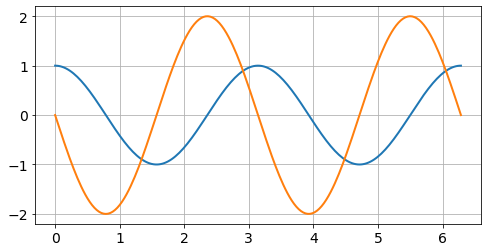

In [34]:
# oppgave 2 utføres her

def opg2():
    # Define the function of the form f(x, y) = y'(x) = y + g(x),
    # where y is a vector of y's
    f = lambda x, y: np.array([
        y[1],
        -4*y[0]
    ])
    
    # Initial values
    y_0 = np.array([1, 0], dtype='float64')
    t_0, t_end = 0, 2*np.pi
    h_0 = 0.1
    tol = 1e-5
    
    
    x, y = bogshamp(t_0, t_end, y_0, f, h_0, tol)
    plt.plot(x, y)
    plt.show()
    
opg2()    
        



# **Oppgave 3**
Anvend rutinen på Brusselator-problemet nedenfor. Sett pessimistfaktor $P=0.9$, bruk
$x_0=0$, $x_{end}=20$, og $tol=10^{-5}$. La $h_0=0.1$.

\begin{align*}
u' &= 1 + u^2 v - 4 u, & u(0)&=1 \\
v' &= 3u - u^2 v,  & v(0)&=2.9
\end{align*}

Lag et plott som viser hver av løsningskomponentene som funksjon av $t$ (i samme plott)
Suppler med et plott rett under dette som viser hvordan skrittlengden varierer med $t$.
Her kan det være nyttig å bruke numpy-funksjonen *diff*.

**Kontrollspørsmål 5-7** Du blir her bedt om å rapportere statistikk fra eksperimentet i Oppgave 3.
Antall skritt koden din bruker, antall funksjonsevalueringer (feval) og antall forkastede skritt.
*NB!* Bruk FSAL-egenskapen, ellers får du gale svar. 

In [2]:
# Oppgave 3 besvares her


def opg3():
    # Define the function of the form f(x, y) = y'(x) = y + g(x),
    # where y is a vector of y's
    f = lambda x, y: np.array([
        1+y[0]**2*y[1]-4*y[0], 
        3*y[0]-y[0]**2*y[1]
    ])
    
    # Initial values
    y_0 = np.array([1, 2.9], dtype='float64')
    t_0, t_end = 0, 20
    h_0 = 0.1
    tol = 1e-5
    
    
    x, y = bogshamp(t_0, t_end, y_0, f, h_0, tol)
    plt.plot(x, y)
    plt.show()
    plt.plot(x, np.diff(x, prepend=0) )
opg3()  

NameError: name 'np' is not defined